In [1]:
import sys
import os

sys.path.append(os.path.abspath("/home/ubuntu/AutoLoRADiscovery/discover_lora_diffusion/weights2weights"))
import torch
import gc
from tqdm import tqdm
from PIL import Image
from lora_w2w import LoRAw2w
from utils import load_models, inference, save_model_w2w, save_model_for_diffusers
from editing import get_direction, edit_inference, debias
import numpy as np

2024-08-08 13:36:56.182018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 13:36:57.572428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mean = torch.load("/mnt/rd/weights2weights/files/mean.pt").bfloat16().to(device)
std = torch.load("/mnt/rd/weights2weights/files/std.pt").bfloat16().to(device)
v = torch.load("/mnt/rd/weights2weights/files/V.pt").bfloat16().to(device)
pinverse = torch.load("/mnt/rd/weights2weights/files/pinverse_1000pc.pt").bfloat16().to(device)
lora_weights = torch.load("/mnt/rd/weights2weights/weights_datasets/identities/all_weights.pt").bfloat16().to(device)
df = torch.load("/mnt/rd/weights2weights/files/identity_df.pt")
weight_dimensions = torch.load("/mnt/rd/weights2weights/files/weight_dimensions.pt")

In [3]:
mean.shape

torch.Size([99648])

In [4]:
# project
def project(weight_item, V, mean, std):
    x = weight_item
    x = x - mean
    x = x / std
    x = torch.matmul(x, V)
    return x



In [31]:
w2w_model_t = project(lora_weights[0:2], v, mean, std)#.unsqueeze(0)
w2w_model = w2w_model_t[1].unsqueeze(0)#(( + w2w_model_t[1]) / 2).unsqueeze(0)

In [32]:
direction1 = get_direction(df = df,label = "Bald", pinverse = pinverse, return_dim = 10000, device =device)

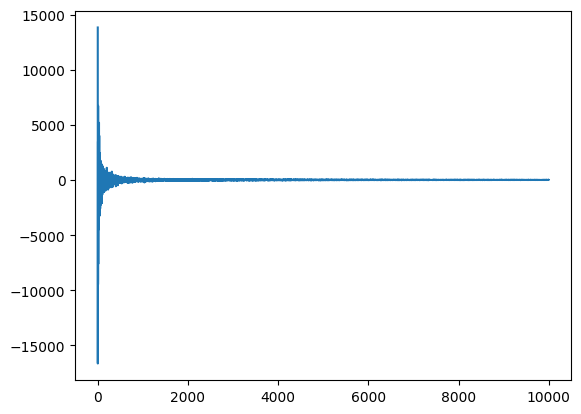

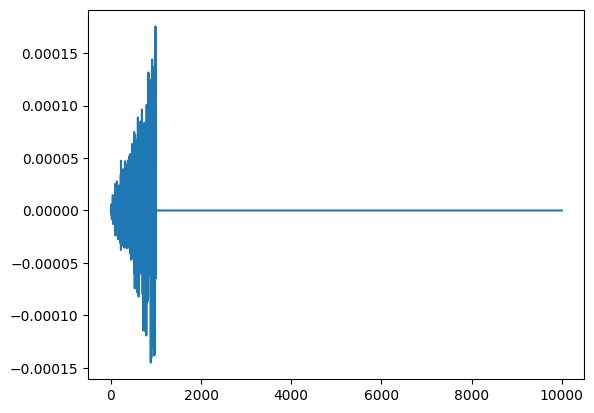

In [33]:
import matplotlib.pyplot as plt

plt.plot(w2w_model[0].float().cpu().numpy())
plt.show()
plt.plot((direction1[0]).float().cpu().numpy())
plt.show()

In [34]:
strength = 0
weights1 = w2w_model+(strength*direction1)

In [28]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)


# Initialize network
network = LoRAw2w(unet=unet,
    proj=weights1,
    mean=mean,
    std=std,
    v=v[:, :10000],
    rank=1,
    multiplier=1.0,
    alpha=27,
    train_method="xattn-strict",
).to(device, dtype=torch.bfloat16)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  6%|▌         | 3/51 [00:00<00:02, 23.25it/s]

100%|██████████| 51/51 [00:02<00:00, 23.35it/s]


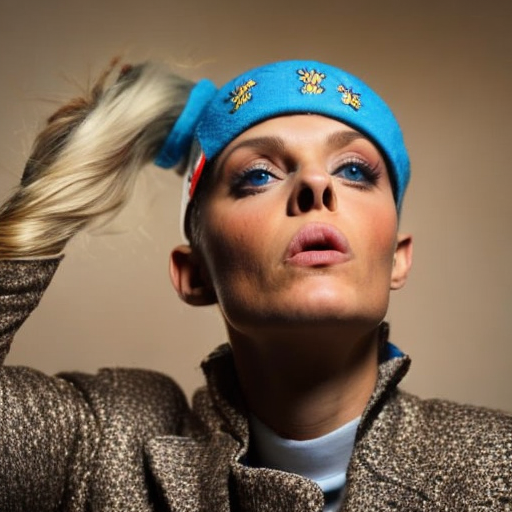

In [30]:
prompt = "sks person"
negative_prompt = "low quality, blurry, unfinished, cartoon"
guidance_scale = 2.5
seed = np.random.randint(0, 1000000)
ddim_steps = 50
start_noise = np.random.randint(400, 1000)

# Random seed generator
generator = torch.Generator(device=device)
generator.manual_seed(seed)

# Run inference
image = edit_inference(network, weights1, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, start_noise, seed, generator, device)
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image.show()

In [ ]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

def generate_edited_lora_datasets(weights0, num_samples=100, save_dir='edited_lora_datasets', device="cuda:0"):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Load necessary files and models


    

    attributes = [
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 
        'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 
        'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 
        'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 
        'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 
        'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 
        'Straight_Hair', 'Wavy_Hair', 'Wearing_Lipstick', 'Young'
    ]

    for attr in tqdm(attributes, desc="Generating datasets for attributes"):
        attr_save_dir = os.path.join(save_dir, attr)
        os.makedirs(attr_save_dir, exist_ok=True)

        direction = get_direction(df=df, label=attr, pinverse=pinverse, return_dim=10000, device=device)
        
        for i in tqdm(range(num_samples), desc=f"Generating samples for {attr}"):
            # Random strength for diversity
            strength = np.random.uniform(500000, 1500000)
            weights1 = weights0 + strength * direction

            # Reinitialize network with new weights
            if 'network' in globals():
                del network
                network = None
                gc.collect()
                torch.cuda.empty_cache()
                unet, _, _, _, _ = load_models(device)

            network = LoRAw2w(unet=unet,
                              proj=weights1,
                              mean=mean,
                              std=std,
                              v=v[:, :10000],
                              rank=1,
                              multiplier=1.0,
                              alpha=27,
                              train_method="xattn-strict",
                              ).to(device, dtype=torch.bfloat16)

            # Inference parameters
            prompt = "sks person"
            negative_prompt = "low quality, blurry, unfinished, cartoon"
            guidance_scale = 2.5
            seed = np.random.randint(0, 1000000)
            ddim_steps = 50
            start_noise = np.random.randint(400, 1000)

            # Random seed generator
            generator = torch.Generator(device=device)
            generator.manual_seed(seed)

            # Run inference
            image = edit_inference(network, weights1, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, start_noise, seed, generator, device)
            image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
            image = Image.fromarray((image * 255).round().astype("uint8"))

            # Save the image
            image.save(os.path.join(attr_save_dir, f"{attr}_{i}.png"))
            clear_gpu_memory()
        clear_gpu_memory()

    print(f"All datasets generated and saved in {save_dir}")

In [7]:
generate_edited_lora_datasets(w2w_model, num_samples=100, save_dir='edited_lora_datasets', device=device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Generating datasets for attributes:   0%|          | 0/33 [00:01<?, ?it/s]


RuntimeError: size mismatch, got input (2), mat (2x4096), vec (320)